# Ultimate Technologies Inc. Data Analysis

**Imports**

In [324]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sys
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import string
import collections
from scipy import stats
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from IPython.display import clear_output
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import Lasso

**Timestamps of user logins based on geolocation**

In [325]:
# Read file
logins_ = pd.read_json(r"C:\Users\yuvem\Downloads\ultimate_challenge_3\ultimate_challenge\logins.json")

In [326]:
# Check shape
logins_.shape

(93142, 1)

**Predictive modeling data**

In [327]:
# Open a connection to json file
ultimate_challenge_file = open(r'C:\Users\yuvem\Downloads\ultimate_challenge_3\ultimate_challenge\ultimate_data_challenge.json', mode='r')
# Read 
ultimate_challenge_json = ultimate_challenge_file.read()

# Close connection
ultimate_challenge_file.close()
# Decode json file
ultimate_challenge_ds = json.loads(ultimate_challenge_json)

# Convert to df
predictive_model_df = pd.DataFrame(ultimate_challenge_ds)

### 1 EDA

In [328]:
logins_.describe()

,login_time
count,93142
unique,92265
top,1970-04-04 01:17:40
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


So, time format is yyyy-mm-dd h:m:s, with first date recorded as 1970-01-01 20:12:16 and last date recorded as 1970-04-13 18:57:38. There is only one column, which is login_time. 

**Goal:**

Our goal with this data is to aggregate the login counts based on 15minute time intervals, visualize, and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. We have to *illustrate* important features of the demand (like daily cycles) and *report* data quality issues.

In [329]:
# Create a column filled with 1's
logins_['fifteen_counts'] = 1

# First, set index as login_time
logins_.set_index('login_time', inplace=True)

# Resample by 15 min intervals
logins_15T = logins_.resample('15T').sum()

# Check
logins_15T.head(5)

,fifteen_counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [330]:
logins_15T.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   fifteen_counts  9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


### 2 Data Wrangling

Okay, so there is a total of 9788 entries, which is going to be a lot of points if plotted. It's probably best to break this down to a hourly, daily, weekly, and monthly. It would be nice to see hourly data and daily data as a seaborn barplot. The weekly, and monthly we will do a time series plot.

**Hourly**

In [331]:
# We resampled earlier by 15 min, now we resample to hourly. Then, we will view the first 24 hours/1 day
login_perHour = logins_.resample('H').sum().reset_index()
login_perHour.rename({'fifteen_counts':'hourly_counts'}, axis=1, inplace=True)
login_perHour.head(24)

,login_time,hourly_counts
0,1970-01-01 20:00:00,24
1,1970-01-01 21:00:00,9
2,1970-01-01 22:00:00,21
3,1970-01-01 23:00:00,58
4,1970-01-02 00:00:00,53
5,1970-01-02 01:00:00,33
6,1970-01-02 02:00:00,43
7,1970-01-02 03:00:00,28
8,1970-01-02 04:00:00,9
9,1970-01-02 05:00:00,11


In [332]:
# Separate dataset with index reset
logins_15T_reset = logins_15T.reset_index()
logins_15T_reset

,login_time,fifteen_counts
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1
...,...,...
9783,1970-04-13 17:45:00,5
9784,1970-04-13 18:00:00,5
9785,1970-04-13 18:15:00,2
9786,1970-04-13 18:30:00,7


In [333]:
# Let's use the dataset with 15min interval. By weekdays, 0=Monday, 6=Sunday
# Create new column 'hour' then sort by 'fifteen_counts'
logins_15T_reset['hour'] = logins_15T_reset['login_time'].dt.hour
# Create a new column 'day' by each day (0-6)
logins_15T_reset['day'] = logins_15T_reset['login_time'].dt.dayofweek
login_hourly = logins_15T_reset.sort_values(by='fifteen_counts', ascending = False)

# Create new dataframe with count and hour
login_hourly_counts = login_hourly[['fifteen_counts', 'hour']]
login_hourly_counts = login_hourly.groupby('hour').sum().reset_index()
login_hourly_counts

,hour,fifteen_counts,day
0,0,5993,1236
1,1,6317,1236
2,2,5800,1236
3,3,4831,1236
4,4,5034,1236
5,5,2945,1236
6,6,1138,1236
7,7,815,1236
8,8,818,1236
9,9,1527,1236


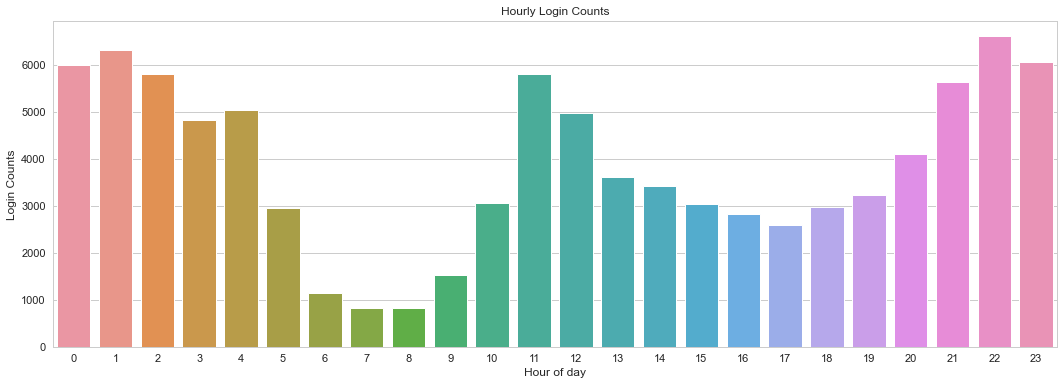

In [334]:
# barplot total logins per hour
plt.figure(figsize=(18,6))
sns.barplot(x= 'hour', y='fifteen_counts', data = login_hourly_counts)
plt.xlabel('Hour of day')
plt.title('Hourly Login Counts')
plt.ylabel('Login Counts')
plt.show()

22:00 is the busiest time and starts quieting down by 2AM, and by 7AM and 8AM it is really slow. Now we have an aggregate per hour of day. What about for each day of the week by hour?

In [335]:
login_perHour.columns

Index(['login_time', 'hourly_counts'], dtype='object')

In [336]:
# We'll use the data resampled to hourly. 
# Create new column 'hour'
login_perHour['hour'] = login_perHour['login_time'].dt.hour
# Create column for day
login_perHour['day'] = login_perHour['login_time'].dt.dayofweek

# Group by day and hour for plot
grouped_login_hourly_byDay = login_perHour.groupby(['day','hour']).sum().reset_index()

In [337]:
grouped_login_hourly_byDay

,day,hour,hourly_counts
0,0,0,531
1,0,1,414
2,0,2,312
3,0,3,236
4,0,4,206
...,...,...,...
163,6,19,632
164,6,20,612
165,6,21,625
166,6,22,583


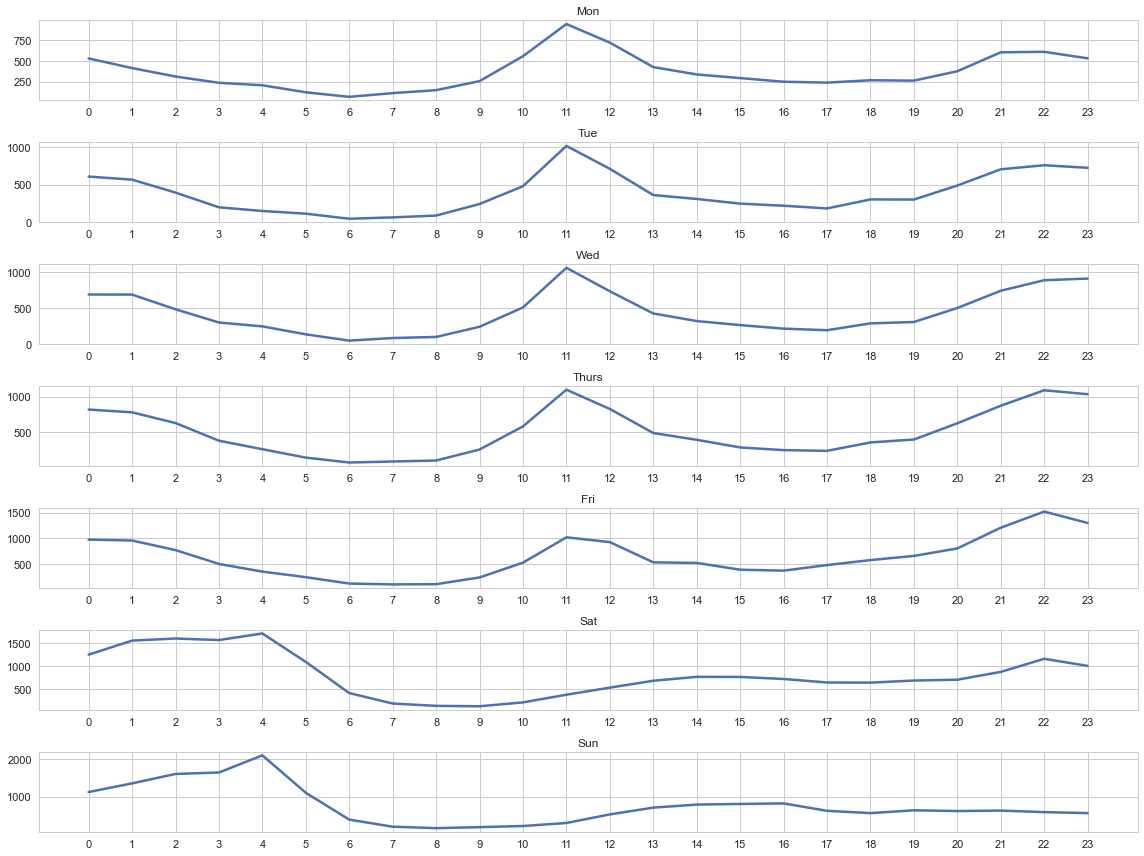

In [338]:
DAY = ['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

# Figure for plot
fig, ax = plt.subplots(nrows=7, figsize=(16, 12))

# For loop for day
# Set 'hour' as index
for i in range(7):
    ax[i].plot(grouped_login_hourly_byDay.loc[grouped_login_hourly_byDay['day']==i, ['hour', 'hourly_counts']].set_index('hour'))
    ax[i].set_title(DAY[i])
    ax[i].set_xticks(np.arange(24))
    
plt.tight_layout()

**Sunday and Saturday are congruous, with peak time being 4AM. Seems like on Fridays 11PM is when the party starts, and on Thursday there are two parties, one at 11AM and the other at 11PM. Afternoons are busiest for weekdays, Monday through Thursday, then dies down from Friday through Sunday. In all days, mornings from 6AM to 8AM are a snooze.** 

**Daily**

In [339]:
# We've got a good idea of the days by hour, but what about an aggregate by day?
# Create a new column 'day' by each day (0-6)
logins_15T_reset['day'] = logins_15T_reset['login_time'].dt.dayofweek
login_daily = logins_15T_reset.sort_values(by='fifteen_counts', ascending=False)

# Create new dataframe with count and hour
login_daily_counts = login_daily[['fifteen_counts', 'day']]
login_daily_counts = login_daily_counts.groupby('day').sum().reset_index()

# Ordered categorical list
login_daily_counts['day'] = ['Mon', 'Tues', 'Wed','Thurs','Fri', 'Sat', 'Sun']
login_daily_counts = login_daily_counts[['day', 'fifteen_counts']]
login_daily_counts

,day,fifteen_counts
0,Mon,8823
1,Tues,9268
2,Wed,10339
3,Thurs,11960
4,Fri,15208
5,Sat,19377
6,Sun,18167


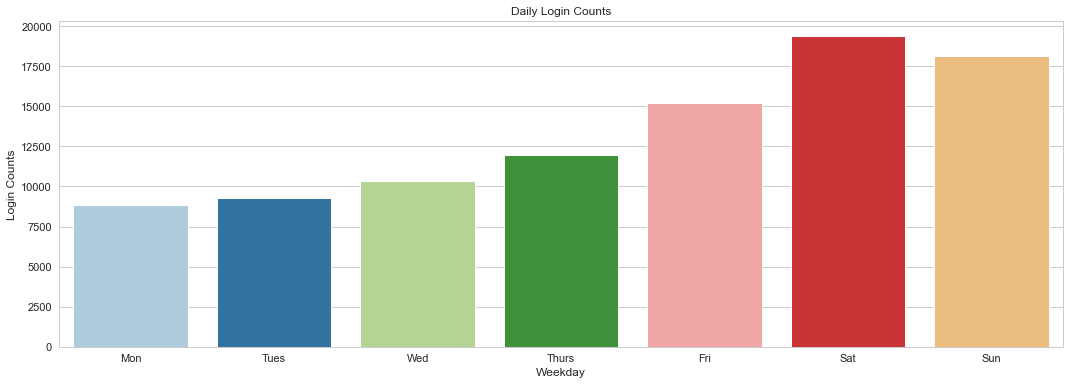

In [340]:
# barplot total logins per day
plt.figure(figsize=(18,6))
sns.set_palette("Paired")
sns.barplot(x= 'day', y='fifteen_counts', data = login_daily_counts)
plt.xlabel('Weekday')
plt.title('Daily Login Counts')
plt.ylabel('Login Counts')
plt.show()

**Most logins recorded on weekends, Saturday and Sunday. Monday has the least logins, and logins increase gradually from Monday to Saturday, then goes down a little bit by Sunday.**

**Monthly**

In [341]:
# Resample data to daily
login_perDay = logins_.resample('1D').sum()
login_perDay.rename({'fifteen_counts':'daily_counts'}, axis=1, inplace=True)

In [342]:
login_perDay_reset = login_perDay.reset_index()

In [343]:
# Create column for month
login_perDay_reset['month'] = login_perDay_reset['login_time'].dt.month
login_perDay_reset

,login_time,daily_counts,month
0,1970-01-01,112,1
1,1970-01-02,681,1
2,1970-01-03,793,1
3,1970-01-04,788,1
4,1970-01-05,459,1
...,...,...,...
98,1970-04-09,818,4
99,1970-04-10,1009,4
100,1970-04-11,1352,4
101,1970-04-12,1409,4


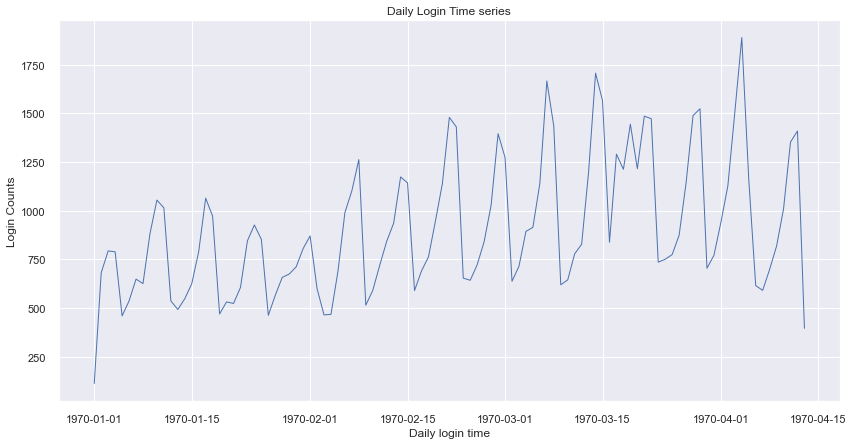

In [344]:
# Plot daily data
plt.style.use('seaborn')
plt.figure(figsize=(14,7))
sns.set(font_scale = 1)
sns.lineplot(data=login_perDay_reset, x='login_time', y='daily_counts', linewidth= 1.0)
plt.xlabel('Daily login time')
plt.ylabel('Login Counts')
plt.title('Daily Login Time series')
plt.show()

So data runs only from January to April, with approximately 15-16 peaks. Let's zoom in and see which months have the most peaks.

In [345]:
# Plot didn't work out with the code below, so I'll try making a dataframe per month
jan = login_perDay[login_perDay.index.month == 1]
feb = login_perDay[login_perDay.index.month == 2]
mar = login_perDay[login_perDay.index.month == 3]
apr = login_perDay[login_perDay.index.month == 4]

# full list of months
months = [jan, feb, mar, apr]

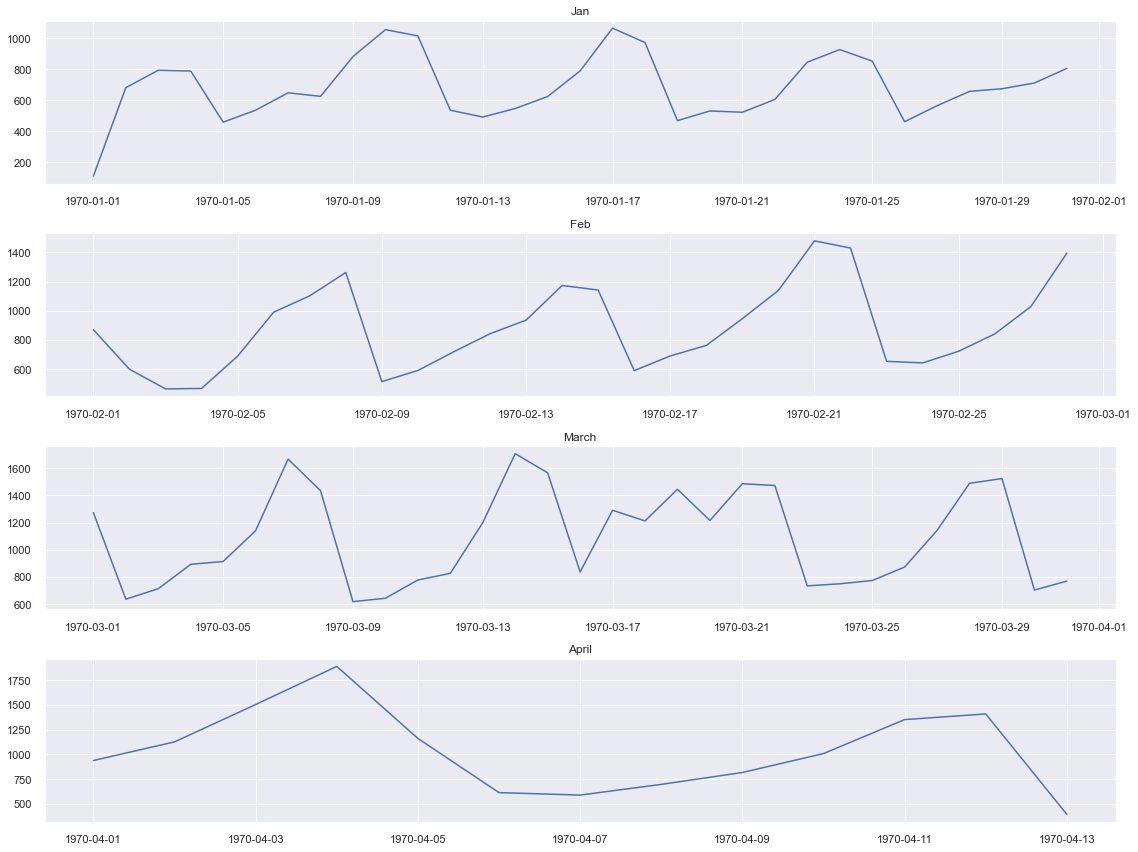

In [346]:
MONTH = ['Jan', 'Feb', 'March', 'April']

# Figure for plot
fig, ax = plt.subplots(nrows=4, figsize=(16, 12))

# For loop for day
# Set 'month' as index
for i2 in range(len(months)):
    ax[i2].plot(months[i2])
    ax[i2].set_title(MONTH[i2])
plt.tight_layout()

**February and May have the most peaks (at least 4 peaks). April has the least, with 2 peaks. Although April has the least peaks, it still has the more logins, with logins increasing montly from Jan-April.**

### 2 Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

The goal is to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. Steps to take are:

   1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
    data for this analysis (a few sentences/plots describing your approach will suffice). What
    fraction of the observed users were retained?
   2. Build a predictive model to help Ultimate determine whether or not a user will be active in
    their 6th month on the system. Discuss why you chose your approach, what alternatives
    you considered, and any concerns you have. How valid is your model? Include any key
    indicators of model performance.
   3. Briefly discuss how Ultimate might leverage the insights gained from the model to
    improve its long term rider retention (again, a few sentences will suffice).

**Data description:**

    ● city: city this user signed up in
    ● phone: primary device for this user
    ● signup_date: date of account registration; in the form ‘YYYYMMDD’
    ● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
    ● avg_dist: the average distance in miles per trip taken in the first 30 days after signup
    ● avg_rating_by_driver: the rider’s average rating over all of their trips
    ● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
    ● surge_pct: the percent of trips taken with surge multiplier > 1
    ● avg_surge: The average surge multiplier over all of this user’s trips
    ● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
    ● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE
    otherwise
    ● weekday_pct: the percent of the user’s trips occurring during a weekday

In [347]:
predictive_model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [348]:
predictive_model_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [349]:
# Get no. of null values per column
predictive_model_df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [350]:
# Check values
predictive_model_df['avg_rating_of_driver'].unique()

array([4.7, 5. , 4.3, 4.6, 4.4, 3.5, nan, 4.5, 4. , 3.9, 4.9, 4.8, 2.5,
       3.7, 1. , 4.1, 4.2, 3. , 3.8, 2. , 2.7, 3.3, 2.8, 3.6, 3.4, 3.2,
       2.6, 3.1, 2.9, 1.7, 1.8, 1.5, 2.3, 1.9, 2.1, 2.4, 1.6, 2.2])

In [351]:
print(predictive_model_df['avg_rating_of_driver'].max())
print(predictive_model_df['avg_rating_of_driver'].min())

5.0
1.0


In [352]:
predictive_model_df['phone'].unique()

array(['iPhone', 'Android', None], dtype=object)

In [353]:
predictive_model_df['avg_rating_by_driver'].unique()

array([5. , 4.9, 4. , 3. , 4.8, 4.7, 4.5, 4.2, nan, 4.4, 4.6, 3.7, 4.3,
       3.5, 2. , 3.8, 2.5, 4.1, 3.9, 1. , 3.3, 3.4, 3.6, 3.2, 2.3, 2.8,
       1.5, 2.7])

In [354]:
print(predictive_model_df['avg_rating_by_driver'].max())
print(predictive_model_df['avg_rating_by_driver'].min())

5.0
1.0


**Data Cleaning**

Okay let's go over the columns with null values. The columns 'avg_rating_of_driver' and 'avg_rating_by_driver' are from 5 to 1, assuming 1 to 5 is from worse to best. We can either fill the nan values by mean or median. We'll use median since it is a resistant measure of center (more resistant to outliers than mean). The 'phone' column has either iPhone or Android, and None we'll assume is either no phone or another brand of phone, so we'll replace it with 'Other'. 

In [355]:
# Make a copy of predictive model data
df_pred_model = predictive_model_df.copy()

# Fill avg_rating_of_driver and avg_rating_by_driver with median value
df_pred_model['avg_rating_of_driver'].fillna(df_pred_model['avg_rating_of_driver'].median(), inplace=True)
df_pred_model['avg_rating_by_driver'].fillna(df_pred_model['avg_rating_by_driver'].median(), inplace=True)
# Fill 'phone' NaN values with 'other'
df_pred_model['phone'].fillna('other', inplace=True)

In [356]:
df_pred_model.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [357]:
# Let's check the values for avg_surge, trips_in_first_30_days, and avg_dist
df_pred_model['trips_in_first_30_days'].unique()

array([  4,   0,   3,   9,  14,   2,   1,   6,  24,   5,   7,  11,  73,
         8,  10,  22,  15,  13,  17,  20,  12,  42,  27,  26,  18,  16,
        40,  28,  19,  23,  33,  48,  31,  71,  25,  21,  34,  29,  30,
        32,  47,  37,  53,  43,  44,  38,  39,  49,  55, 125,  41,  50,
        63,  35,  54,  56,  36,  51,  58], dtype=int64)

In [358]:
df_pred_model['avg_surge'].unique()

array([1.1 , 1.  , 1.14, 1.19, 1.38, 1.21, 1.17, 1.02, 1.05, 1.5 , 2.  ,
       1.25, 1.04, 1.88, 1.33, 1.56, 1.06, 1.03, 1.09, 1.35, 3.5 , 1.11,
       1.63, 2.5 , 1.32, 1.3 , 1.75, 2.25, 1.2 , 1.13, 1.08, 1.15, 4.  ,
       1.12, 1.22, 1.29, 1.23, 1.01, 1.07, 1.18, 1.45, 2.75, 2.63, 1.46,
       2.07, 1.27, 3.  , 1.36, 1.96, 1.42, 1.44, 1.54, 1.16, 1.31, 1.58,
       1.92, 1.67, 1.26, 4.75, 1.41, 3.25, 1.24, 2.13, 1.6 , 1.57, 1.34,
       1.52, 1.69, 5.  , 1.4 , 1.37, 1.7 , 1.78, 1.43, 1.94, 1.64, 1.83,
       1.28, 1.85, 1.55, 1.48, 1.39, 2.88, 4.25, 1.47, 1.51, 1.9 , 1.68,
       4.5 , 1.66, 2.33, 1.65, 1.71, 2.17, 2.38, 1.61, 2.08, 3.75, 8.  ,
       1.77, 1.49, 2.42, 1.59, 1.8 , 2.19, 1.53, 1.81, 5.75, 1.79, 2.44,
       2.67, 2.31, 2.1 , 2.2 , 3.63])

In [359]:
df_pred_model['avg_dist'].unique()

array([ 3.67,  8.26,  0.77, ..., 38.72, 27.47, 30.39])

In [360]:
# Check max and min of each column
print(df_pred_model['avg_dist'].max())
print(df_pred_model['avg_dist'].min())

160.96
0.0


In [361]:
print(df_pred_model['avg_surge'].max())
print(df_pred_model['avg_surge'].min())

8.0
1.0


In [362]:
print(df_pred_model['trips_in_first_30_days'].max())
print(df_pred_model['trips_in_first_30_days'].min())

125
0


Let's say anyone who has made 0 trips is not active. 

In [363]:
# Create a separate dataframe for active and not_active users
active = df_pred_model[df_pred_model.trips_in_first_30_days > 0].copy()
not_active = df_pred_model[df_pred_model.trips_in_first_30_days == 0].copy()

In [364]:
# Count how many active and not_active people there are
print(len(active), 'Percent of active users are: ', len(active)/(len(not_active)+len(active))*100)
print(len(not_active), 'Percent of inactive users are: ', len(not_active)/(len(not_active)+len(active))*100)

34610 Percent of active users are:  69.22
15390 Percent of inactive users are:  30.78


Perhaps it's a good idea to get a visual between active vs. inactive users. 

In [365]:
# Float features
floats = df_pred_model.dtypes == np.float64
# Turn into list
floats_cols = df_pred_model.columns[floats].tolist()
print(floats_cols)

['avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']


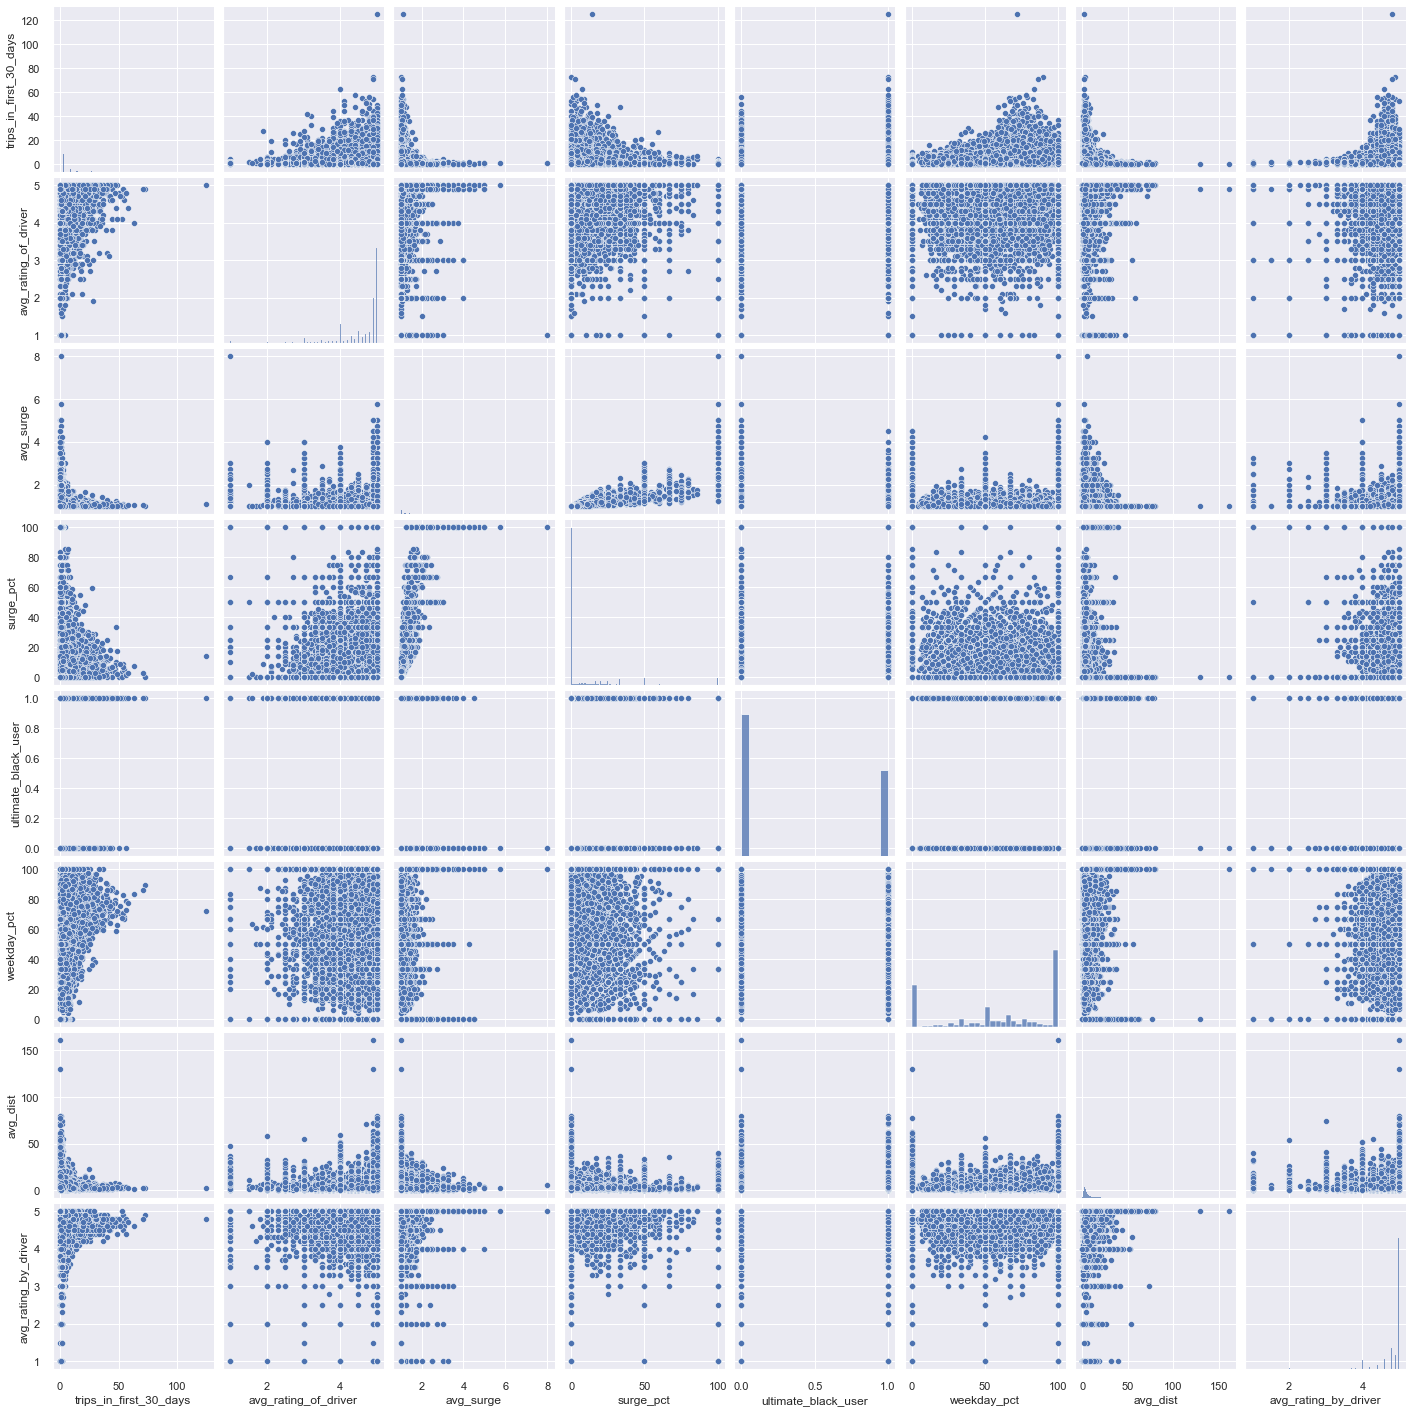

In [366]:
sns.pairplot(df_pred_model)

In [367]:
# Going to check values for 'last_trip_date'
df_pred_model.last_trip_date.unique()
print(df_pred_model.last_trip_date.dtype)

object


In [368]:
# For loop that specifies if the last trip is taken within 30 days 6 months from the start. We can treat active and inactive
# users as boolean, 0=inactive 1=active

ACTIVE = []

for m in range(len(df_pred_model)):
    start_ = pd.Timestamp(df_pred_model['signup_date'][i])
    end_ = start_+ pd.Timedelta('181D')
    month_ago = end_- pd.Timedelta('30D')
    if month_ago <= pd.Timestamp(df_pred_model.last_trip_date [m]) <= end_:
        ACTIVE.append(1)
    else:
        ACTIVE.append(0)
        
# Add 'active' as a column
df_pred_model['active'] = ACTIVE
df_pred_model.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


Hold on, it's a probably a good idea to find which columns are categorical and which are numerical, and also convert these values to their respective datatype.

In [369]:
# Categorical features
cats = df_pred_model.dtypes == np.object
# Turn into list
cats_cols = df_pred_model.columns[cats].tolist()
print(cats_cols)

['city', 'signup_date', 'last_trip_date', 'phone']


In [370]:
# Numerical features
nums = df_pred_model.dtypes == np.number
# Turn into list
nums_cols = df_pred_model.columns[nums].tolist()
print(nums_cols)

['avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']


In [371]:
# Integer features
ints = df_pred_model.dtypes == np.int64
# Turn into list
ints_cols = df_pred_model.columns[ints].tolist()
print(ints_cols)

['trips_in_first_30_days', 'active']


In [372]:
# Float features
floats = df_pred_model.dtypes == np.float64
# Turn into list
floats_cols = df_pred_model.columns[floats].tolist()
print(floats_cols)

['avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']


**T tests**

The t-test is a parametric test of difference, meaning that it makes the same assumptions about your data as other parametric tests. The t-test assumes your data: are independent; are (approximately) normally distributed. have a similar amount of variance within each group being compared (a.k.a. homogeneity of variance) [Scribbr](https://www.scribbr.com/statistics/t-test/).

In [373]:
# Create a list containing all columns with numeric values
FLOATS = [col for col in df_pred_model.columns if df_pred_model[col].dtype =='float64']

# for loop
for col in FLOATS:
    tscore = stats.ttest_ind(active[col], not_active[col])
    print('T-score for {}:{}'.format(col, tscore))

T-score for avg_rating_of_driver:Ttest_indResult(statistic=-12.399303029416846, pvalue=2.970601535329053e-35)
T-score for avg_surge:Ttest_indResult(statistic=2.3094461301357625, pvalue=0.020922892160045396)
T-score for surge_pct:Ttest_indResult(statistic=2.5144681086090093, pvalue=0.011924321064206714)
T-score for weekday_pct:Ttest_indResult(statistic=-1.5009641436435157, pvalue=0.1333711507019858)
T-score for avg_dist:Ttest_indResult(statistic=-15.740996629836083, pvalue=1.0779678630353311e-55)
T-score for avg_rating_by_driver:Ttest_indResult(statistic=-4.489643639133461, pvalue=7.150162715034273e-06)


In [374]:
# City names
df_pred_model.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [375]:
# Dates
df_pred_model.signup_date.unique()

array(['2014-01-25', '2014-01-29', '2014-01-06', '2014-01-10',
       '2014-01-27', '2014-01-09', '2014-01-24', '2014-01-28',
       '2014-01-21', '2014-01-03', '2014-01-13', '2014-01-15',
       '2014-01-11', '2014-01-12', '2014-01-02', '2014-01-31',
       '2014-01-19', '2014-01-16', '2014-01-26', '2014-01-05',
       '2014-01-17', '2014-01-22', '2014-01-18', '2014-01-20',
       '2014-01-04', '2014-01-30', '2014-01-07', '2014-01-01',
       '2014-01-08', '2014-01-23', '2014-01-14'], dtype=object)

In [376]:
# Dates
df_pred_model.last_trip_date.unique()

array(['2014-06-17', '2014-05-05', '2014-01-07', '2014-06-29',
       '2014-03-15', '2014-06-06', '2014-01-25', '2014-01-29',
       '2014-02-01', '2014-01-05', '2014-05-30', '2014-01-10',
       '2014-03-12', '2014-06-08', '2014-01-28', '2014-01-16',
       '2014-06-28', '2014-07-01', '2014-06-24', '2014-06-03',
       '2014-03-16', '2014-04-29', '2014-05-02', '2014-06-13',
       '2014-05-18', '2014-01-03', '2014-01-22', '2014-03-05',
       '2014-02-27', '2014-02-07', '2014-06-14', '2014-06-10',
       '2014-02-28', '2014-01-17', '2014-02-21', '2014-06-25',
       '2014-04-26', '2014-06-30', '2014-06-23', '2014-05-10',
       '2014-01-26', '2014-03-17', '2014-06-18', '2014-04-19',
       '2014-01-19', '2014-06-19', '2014-02-15', '2014-06-01',
       '2014-05-16', '2014-06-15', '2014-03-10', '2014-04-20',
       '2014-03-29', '2014-02-02', '2014-05-09', '2014-05-04',
       '2014-03-19', '2014-04-23', '2014-01-01', '2014-01-08',
       '2014-04-27', '2014-01-30', '2014-02-03', '2014-

In [377]:
# Function to convert to datetime
def to_datetime(df):
    date = pd.to_datetime(df)
    return date

In [378]:
to_datetime(df_pred_model.last_trip_date)

0       2014-06-17
1       2014-05-05
2       2014-01-07
3       2014-06-29
4       2014-03-15
           ...    
49995   2014-06-05
49996   2014-01-25
49997   2014-05-22
49998   2014-01-15
49999   2014-04-20
Name: last_trip_date, Length: 50000, dtype: datetime64[ns]

In [379]:
to_datetime(df_pred_model.signup_date)

0       2014-01-25
1       2014-01-29
2       2014-01-06
3       2014-01-10
4       2014-01-27
           ...    
49995   2014-01-25
49996   2014-01-24
49997   2014-01-31
49998   2014-01-14
49999   2014-01-18
Name: signup_date, Length: 50000, dtype: datetime64[ns]

In [380]:
df_pred_model

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,0
49996,Astapor,1,2014-01-24,4.9,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,0


In [381]:
# Create separate dataframe without date and time
date_n_time_cols = ['last_trip_date', 'signup_date']
pred_model_no_date = df_pred_model.drop(date_n_time_cols, axis=1)

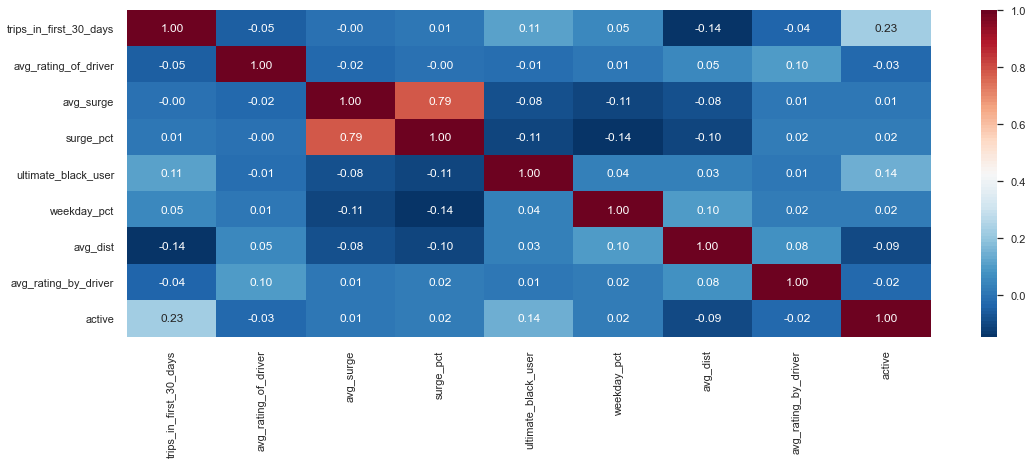

In [382]:
# Plot heatmap for correlation of numeric features
corr_data = pred_model_no_date.corr()
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(18,6))
sns.set_context("notebook",font_scale = 1.0, rc = {"lines.linewidth":2.5})
ax1 = sns.heatmap(pred_model_no_date.corr(), annot = True, fmt = ".2f", cmap=sns.color_palette('RdBu_r', 100))
plt.show()

### 3 OneHot Encoding

In [383]:
# Going to first udpate the cats_cols using the pred_model_no_date df
# Categorical features
cats2 = pred_model_no_date.dtypes == np.object
# Turn into list
cats_cols2 = pred_model_no_date.columns[cats2].tolist()
print(cats_cols2)

['city', 'phone']


In [384]:
y = pred_model_no_date['active']
X = pred_model_no_date.drop('active', axis=1)

In [385]:
# Get_dummies for X 
x_getdum = pd.get_dummies(X, columns= cats_cols2, prefix_sep='_', drop_first=True)
X = x_getdum
X.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_King's Landing,city_Winterfell,phone_iPhone,phone_other
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,1,0,1,0
1,0,5.0,1.00,0.0,False,50.0,8.26,5.0,0,0,0,0
2,3,4.3,1.00,0.0,False,100.0,0.77,5.0,0,0,1,0
3,9,4.6,1.14,20.0,True,80.0,2.36,4.9,1,0,1,0
4,14,4.4,1.19,11.8,False,82.4,3.13,4.9,0,1,0,0


### 4 RandomForest 

Ranking of features:
1. feature 6 (0.29)
2. feature 5 (0.16)
3. feature 3 (0.11)
4. feature 0 (0.09)
5. feature 7 (0.09)
6. feature 1 (0.09)
7. feature 2 (0.09)
8. feature 4 (0.02)
9. feature 8 (0.02)
10. feature 10 (0.02)
11. feature 9 (0.01)
12. feature 11 (0.00)


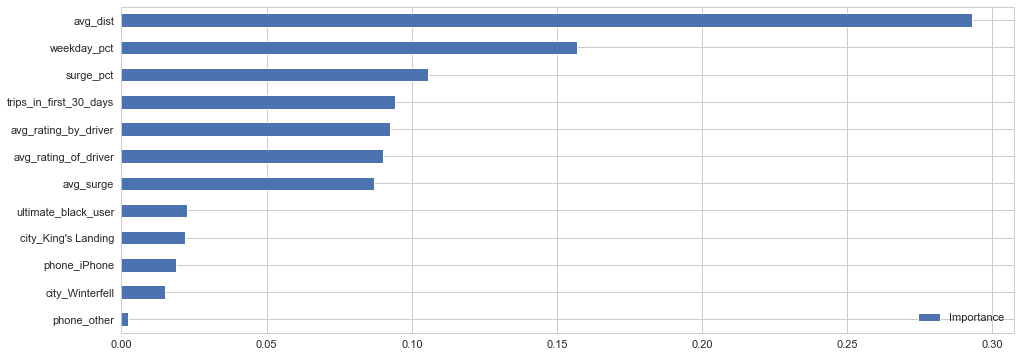

In [413]:
rfc = RandomForestClassifier(n_estimators=10,
                             criterion='gini')
rfc.fit(X, y)

# Plot
plt.style.use('seaborn-whitegrid')
feature_importances = rfc.feature_importances_

# Define sigma and indexes
sigma = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indexes = np.argsort(feature_importances)[::-1]

# Print Ranking of features
print("Ranking of features:")
for v in range(X.shape[1]):
    print("%d. feature %d (%.2f)" % (v + 1, indexes[v], feature_importances[indexes[v]]))
    
# Define plot
df_feature_importance = pd.DataFrame(feature_importances, index=X.columns, columns=["Importance"])
df_feature_importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize = (16,len(feature_importances)/2));

In [414]:
# Cross validate rfc model
rfc_default_cv_results = cross_validate(rfc, X_train, y_train, cv=5)

In [415]:
# RFC cross-validation scores
rfc_cv_scores = rfc_default_cv_results['test_score']
rfc_cv_scores

array([0.82133333, 0.81986667, 0.82106667, 0.82173333, 0.81893333])

In [416]:
# mu and signma
np.mean(rfc_cv_scores), np.std(rfc_cv_scores)

(0.8205866666666666, 0.0010348590886364)

### 5 GridSearchCV

In [429]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [430]:
rfc.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [431]:
# Let's call GridSearchCV with the rfc model, 5-fold cross-validation
rfc_grid_cv = GridSearchCV(estimator=rfc, param_grid=grid_params, cv= 5)

In [432]:
rfc.fit(X_train, y_train)
print(rfc.best_estimator_)

AttributeError: 'RandomForestClassifier' object has no attribute 'best_estimator_'

### 5 XGBoost

In [387]:
# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

XGB_model = XGBClassifier()
XGB_model.fit(X_train, y_train)

[22:26:44] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [388]:
# y_predct as predictions for test data
y_predict = XGB_model.predict(X_test)
predict = [round(value) for value in y_predict]

# Check predictions
score = accuracy_score(y_test, predict)
print("Accuracy score: %.2f%% " % (score*100))

Accuracy score: 83.54% 


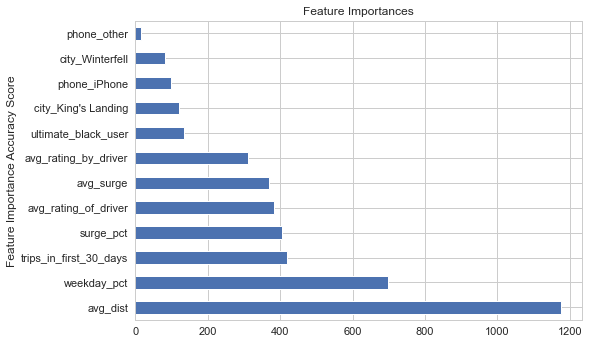

<Figure size 1440x576 with 0 Axes>

In [389]:
# Feature of importances plot
importances = pd.Series(XGB_model.get_booster().get_fscore()).sort_values(ascending=False)
importances.plot(kind='barh', title='Feature Importances')
plt.ylabel('Feature Importance Accuracy Score')
plt.figure(figsize=(20,8))
plt.show()

### 6 ROC Curve

In [ ]:
print(metrics.classification_report(y_train, train_pred_rf))